# Gerrychain demo with Iowa data


## 1. Gathering the data and installing libraries

First, let's install GerryChain. The best way to install GerryChain on your local machine is to use conda, but we'll use pip here. Check out https://gerrychain.readthedocs.io/en/latest/user/install.html for installation guide.

In [ ]:
!pip install gerrychain

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 931kB 6.4MB/s 
     |████████████████████████████████| 14.7MB 308kB/s 
     |████████████████████████████████| 10.9MB 47.9MB/s 


We will need some clean data. We will use the Iowa county shapefile available on mggg-states.

In [ ]:
#clone the IA shapefiles repo from github
!git clone https://github.com/mggg-states/IA-shapefiles.git

Cloning into 'IA-shapefiles'...
remote: Enumerating objects: 12, done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 12
Unpacking objects: 100% (12/12), done.


In [ ]:
#unzip the counties shapefile
!unzip IA-shapefiles/IA_counties.zip

Archive:  IA-shapefiles/IA_counties.zip
  inflating: IA_counties.dbf         
  inflating: IA_counties.shx         
  inflating: IA_counties.shp         
   creating: __MACOSX/
  inflating: __MACOSX/._IA_counties.shp  
  inflating: IA_counties.cpg         
  inflating: IA_counties.prj         


Let's import everything we will need from GerryChain, plus a few extra things.

In [1]:
from gerrychain import Graph, Election, updaters, Partition, constraints, MarkovChain, accept, GeographicPartition
from gerrychain.updaters import cut_edges
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part, bipartition_tree
from gerrychain.accept import always_accept
from gerrychain.constraints import single_flip_contiguous, contiguous

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from functools import partial

import random
random.seed(42)

In [2]:
district_path = "../../data/MN_precincts.geojson"

gdf = gpd.read_file(district_path)
print(gdf.columns)
gdf['MNLEGDIST']

Index(['VTDID', 'PCTNAME', 'PCTCODE', 'MCDNAME', 'MCDCODE', 'CTU_TYPE',
       'COUNTYNAME', 'COUNTYFIPS', 'CONGDIST', 'MNSENDIST', 'MNLEGDIST',
       'CTYCOMDIST', 'JUDDIST', 'TOTVOT16', 'PRES16R', 'PRES16D', 'PRES16G',
       'PRES16I', 'PRES16L', 'USH16R', 'USH16D', 'SSEN16R', 'SSEN16D', 'SH16R',
       'SH16D', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'geometry'],
      dtype='object')


0       10B
1       10B
2       10B
3       10B
4       10B
       ... 
4115    16A
4116    16A
4117    16A
4118    16A
4119    16A
Name: MNLEGDIST, Length: 4120, dtype: object

Let's look at our shapefile.

<Axes: >

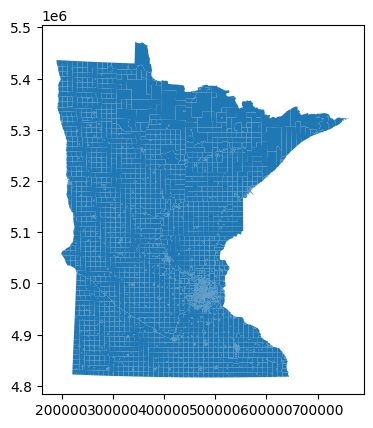

In [3]:
gdf = gpd.read_file(district_path)
gdf.plot()

## 2. Setting up the initial plan and updaters for the chain

We have to convert the shapefile into a GerryChain Graph object. This can take a _really_ long time for big states. For Iowa it might take a few seconds. For that reason, it's a good idea to save your graph straight away so you can load it next time from a .json file.

In [4]:
graph = Graph.from_geodataframe(gdf)

As GerryChain generates districting plans, we can read off properties of the plans (such as district vote shares or populations) using _updaters_. Since every shapefile is different, we need to create updaters for population, cut edges (discretized boundary length) and elections. Here are Iowa's:

In [5]:
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": updaters.cut_edges,
    "perimeter": updaters.perimeter,
    "area": updaters.Tally("area", alias="area"),
}

election_names = ["PRES16","USH16","SSEN16","SH16"] 
election_columns = [["PRES16D", "PRES16R"],["USH16D", "USH16R"],["SSEN16D", "SSEN16R"],["SH16D","SH16R"]]
elections = [
    Election(name,{"Democratic": dem, "Republican": rep})
    for name, (dem, rep) in zip(election_names, election_columns)
]
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

initial_partition = GeographicPartition(
    graph,
    assignment="MNSENDIST",
    updaters=my_updaters
)

We need an initial plan to start the chain at. Here's how to make one from scratch. This can take a while too, so you can also use an enacted plan as a seed if you have one on the shapefile. **You can change the number of districts (4) and the maximum population deviation if you like.**

In [6]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=0.01,
    node_repeats=2,
)

recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=20,
)

Let's look at our seed plan. Here's an easy way to see a Partition object as a plan.

<Axes: title={'center': 'Initial Partition in MN'}>

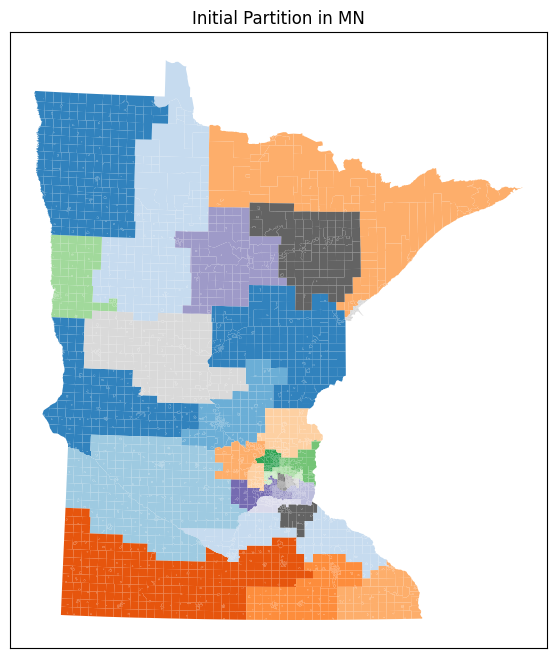

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Initial Partition in MN")
initial_partition.plot(ax=ax, cmap='tab20c')

In [8]:
for i, partition in enumerate(recom_chain):
    print(i, partition)

0 <GeographicPartition [67 parts]>
1 <GeographicPartition [67 parts]>
2 <GeographicPartition [67 parts]>
3 <GeographicPartition [67 parts]>
4 <GeographicPartition [67 parts]>
5 <GeographicPartition [67 parts]>
6 <GeographicPartition [67 parts]>
7 <GeographicPartition [67 parts]>
8 <GeographicPartition [67 parts]>
9 <GeographicPartition [67 parts]>
10 <GeographicPartition [67 parts]>
11 <GeographicPartition [67 parts]>
12 <GeographicPartition [67 parts]>
13 <GeographicPartition [67 parts]>
14 <GeographicPartition [67 parts]>
15 <GeographicPartition [67 parts]>
16 <GeographicPartition [67 parts]>
17 <GeographicPartition [67 parts]>
18 <GeographicPartition [67 parts]>
19 <GeographicPartition [67 parts]>


In [17]:
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import pandas as pd

import matplotlib.cm as mcm
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

frames = []
district_data = []
voteshare_data = {e: [] for e in election_names}

initial = []

for i, partition in enumerate(recom_chain):
    
    # Check if plans different from initial
    if initial == []:
        initial = [partition.assignment[n] for n in graph.nodes]

    if initial != [partition.assignment[n] for n in graph.nodes]:
        print("Different from inital plan")    

    # Store district plan 
    gdf['PLAN_{}'.format(i)] = [partition.assignment[n] for n in graph.nodes]

    # Store district data
    for district_name in partition.perimeter.keys():
        population = partition.population[district_name]
        perimeter = partition.perimeter[district_name]
        area = partition.area[district_name]
        district_data.append((i, district_name, population, perimeter, area))

    # Store voteshare data (per district?)
    for e in election_names:
        voteshare_data[e].append(sorted(partition[e].percents("Democratic")))

    buffer = io.BytesIO()
    fig, ax = plt.subplots(figsize=(10,10))
    partition.plot(ax=ax, cmap='tab20')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    frames.append(image)
    plt.close(fig)

df = pd.DataFrame(
    district_data,
    columns=[
        'step',
        'district_name',
        'population',
        'perimeter',
        'area'
    ]
)

def show_frame(idx):
    clear_output(wait=True)
    display(frames[idx])

slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')
slider.layout.width = '500px'
widgets.interactive(show_frame, idx=slider)

Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan
Different from inital plan


interactive(children=(IntSlider(value=0, description='Frame:', layout=Layout(width='500px'), max=19), Output()…

In [18]:
# DATA: proerties of district plans
df

,step,district_name,population,perimeter,area
0,0,10,78702.0,4.208784e+05,8.156826e+09
1,0,35,79047.0,6.486097e+04,1.722802e+08
2,0,31,78995.0,1.742043e+05,1.162097e+09
3,0,37,79243.0,4.723362e+04,1.009246e+08
4,0,38,79129.0,1.051656e+05,2.768811e+08
...,...,...,...,...,...
1335,19,64,79300.0,3.474078e+04,3.996084e+07
1336,19,65,79672.0,3.956411e+04,5.363200e+07
1337,19,67,79654.0,4.473511e+04,5.089269e+07
1338,19,7,79634.0,1.325809e+06,2.716119e+10


In [19]:
# DATA: original shapefile + district plans
fresh_gdf = gpd.read_file(district_path)

for i in range(len(recom_chain)):
    fresh_gdf['plan_{}'.format(i)] = gdf['recomstep{}'.format(i)]

fresh_gdf

,VTDID,PCTNAME,PCTCODE,MCDNAME,MCDCODE,CTU_TYPE,COUNTYNAME,COUNTYFIPS,CONGDIST,MNSENDIST,...,plan_10,plan_11,plan_12,plan_13,plan_14,plan_15,plan_16,plan_17,plan_18,plan_19
0,270010005,Aitkin,0005,Aitkin,004,city,Aitkin,001,8,10,...,10,10,10,10,10,10,10,10,10,10
1,270010010,Aitkin Twp,0010,Aitkin Twp,005,township,Aitkin,001,8,10,...,10,10,10,10,10,10,10,10,10,10
2,270010015,Ball Bluff Twp,0015,Ball Bluff Twp,015,township,Aitkin,001,8,10,...,10,10,10,10,10,10,10,10,10,10
3,270010020,Balsam Twp,0020,Balsam Twp,020,township,Aitkin,001,8,10,...,10,10,10,10,10,10,10,10,10,10
4,270010025,Beaver Twp,0025,Beaver Twp,025,township,Aitkin,001,8,10,...,10,10,10,10,10,10,10,10,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4115,271730145,Swede Prairie Twp,0145,Swede Prairie Twp,120,township,Yellow Medicine,173,7,16,...,16,16,16,16,16,16,16,16,16,16
4116,271730150,Tyro Twp,0150,Tyro Twp,125,township,Yellow Medicine,173,7,16,...,16,16,16,16,16,16,16,16,16,16
4117,271730155,Wergeland Twp,0155,Wergeland Twp,130,township,Yellow Medicine,173,7,16,...,16,16,16,16,16,16,16,16,16,16
4118,271730160,Wood Lake,0160,Wood Lake,134,city,Yellow Medicine,173,7,16,...,16,16,16,16,16,16,16,16,16,16


In [20]:
fresh_gdf.to_file("../proposals/MN_VTDs_with_recom.shp")

## 3. Running a flip walk chain

We need some constraints on what kind of plans our chain can generate. For flip walks, we are worried about contiguity and population balance. **Go ahead and tinker with the number of steps and the population deviation if you like.**

In [33]:
myconstraints = [
    single_flip_contiguous, #fast contiguity tracker only for flip walks
    constraints.within_percent_of_ideal_population(initial_partition, 0.05) #population deviation
]
chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=myconstraints,
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000 #number of steps
)

It's time to run a chain. A GerryChain MarkovChain object is iterable -- in other words, you run it like you're iterating through a list.

It's no good running the chain without storing something about the plans to look at, so let's store the Democratic vote shares for each plan, sorted in ascending order. We'll store the data in a list to start with, and then put it in a pandas DataFrame, which is easy to store as a csv later on. We'll also store the cut edges in a separate list. **You can also store any other data you like, for example step[e].seats('Democratic') gives you the number of Democratic-won districts.**

It's also good practice, when space is available, to store your partitions on the shapefile so you can look at them later. Let's store our plans as step1, step2 etc.

In [35]:
votesharelists = {e: [] for e in election_names}
cutedges = []
for i, step in enumerate(chain):
  print(i, end=" ")
  cutedges.append(len(step['cut_edges'])) #store cut edges
  gdf['flipstep{}'.format(i)] = [step.assignment[n] for n in graph.nodes] #store plan
  # for e in election_names:
  #   votesharelists[e].append(sorted(step[e].percents("Democratic")))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 

/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 

/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 

/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 

/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

Let's look at the tenth plan in the chain. **Go ahead and change the number to see different plans in the chain. Can you see what changes from one plan to the next?**


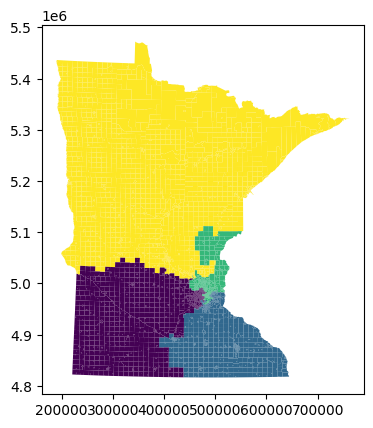

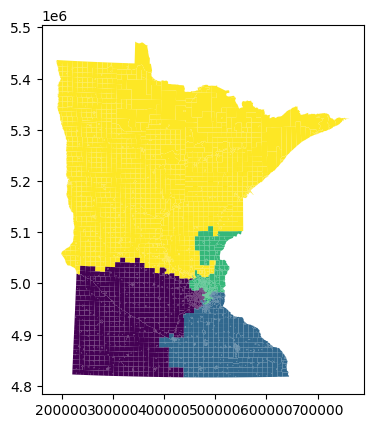

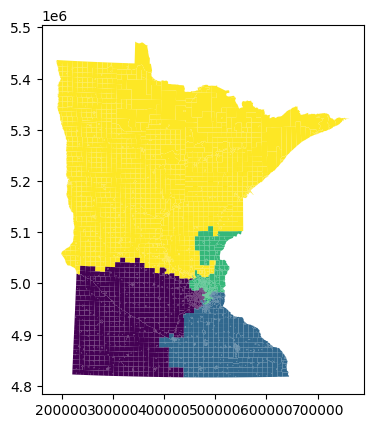

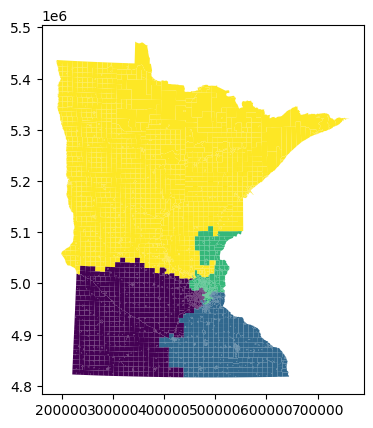

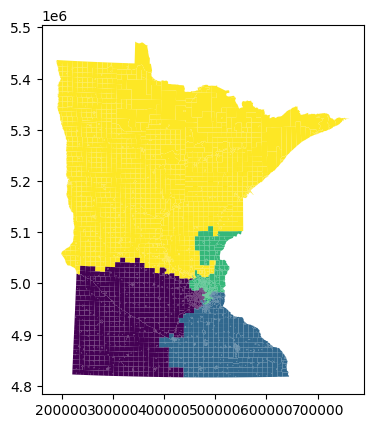

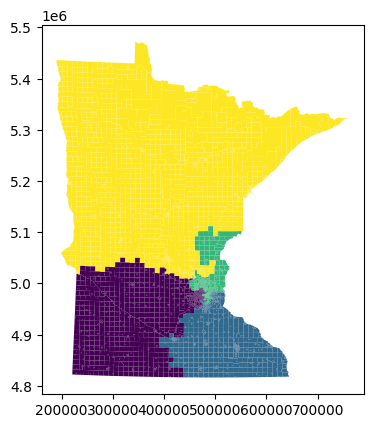

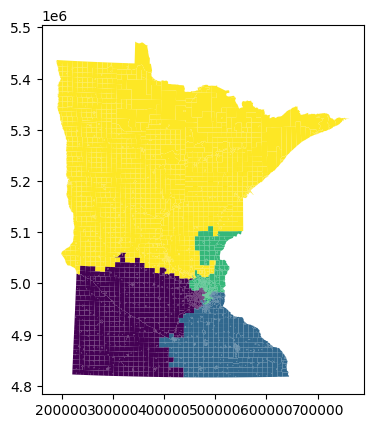

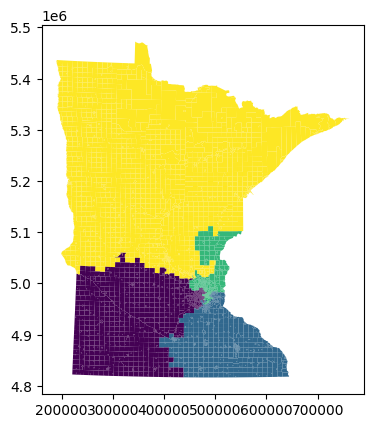

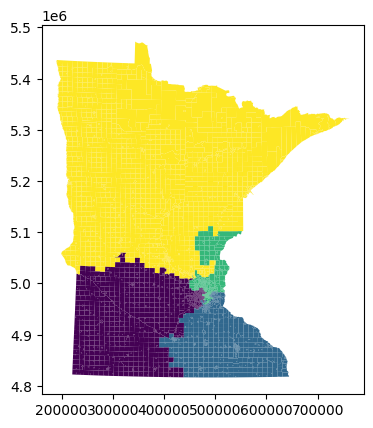

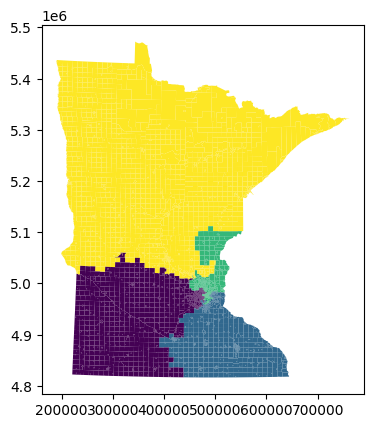

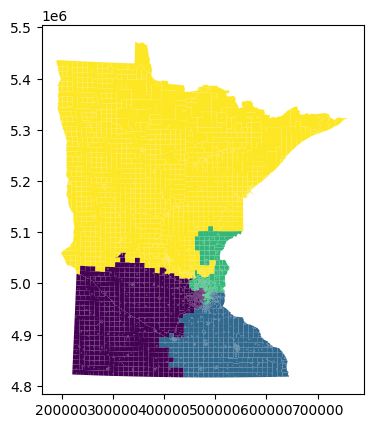

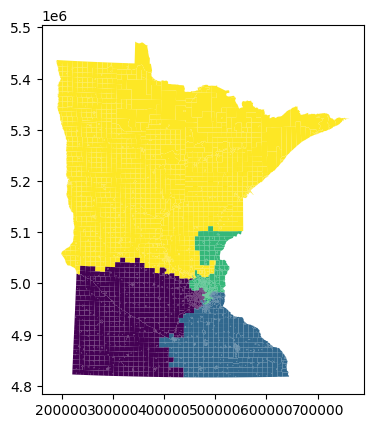

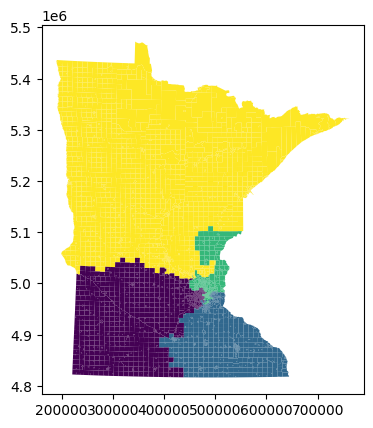

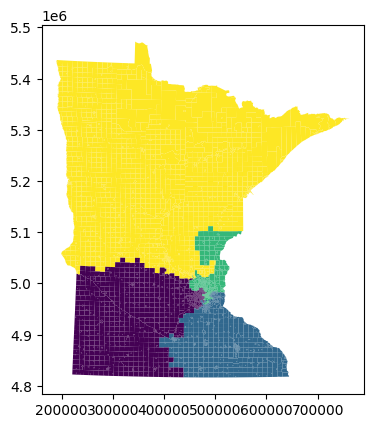

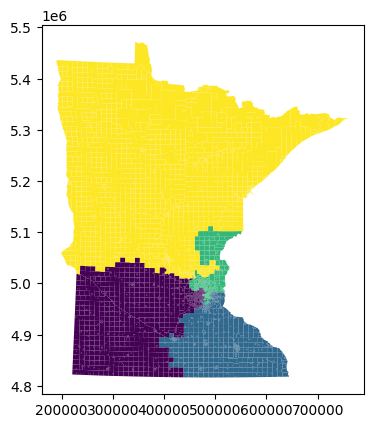

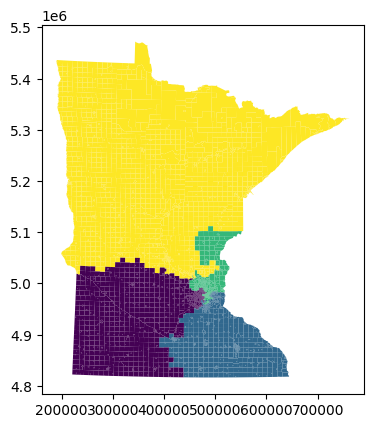

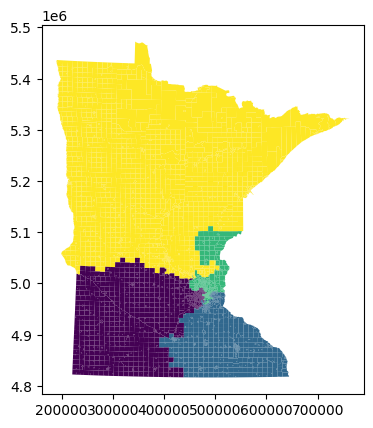

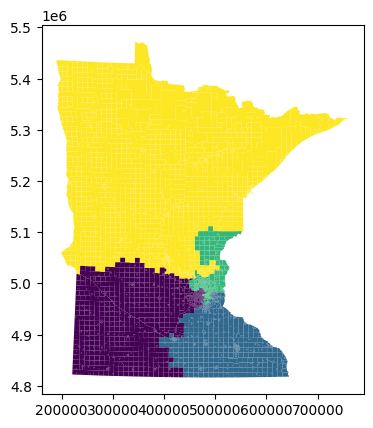

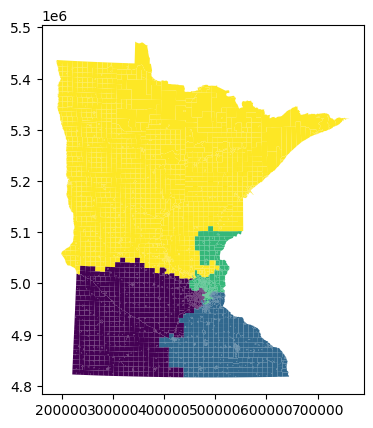

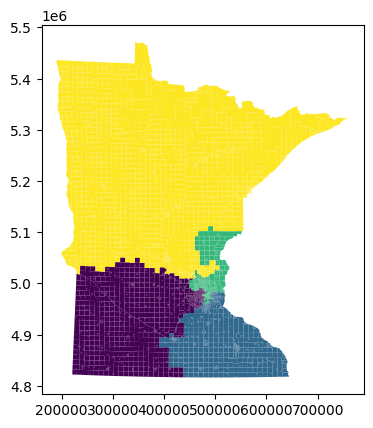

In [37]:
for i in range(20):
  gdf.plot(column="flipstep{}".format(i))

Let's look at our data. We'll pick one election and look at a box plot of the vote shares. In the plot, District 0 is the least Democratic district, District 1 the second-least Democratic and so on. **We'll use PRES12 but you can use any election you like.**

In [14]:
flipvoteshares = pd.DataFrame(votesharelists['PRES12']) #put it in a pandas DataFrame
flipvoteshares.head()

,0,1,2,3
0,0.431793,0.543316,0.546293,0.592866
1,0.431793,0.543316,0.546846,0.591773
2,0.431793,0.542697,0.547393,0.591773
3,0.426879,0.542697,0.546605,0.591773
4,0.431793,0.542697,0.547393,0.591773


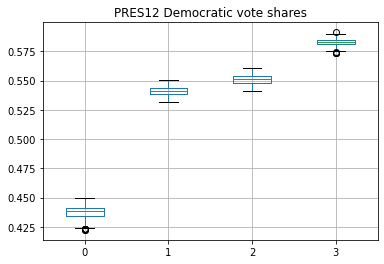

In [ ]:
flipvoteshares.boxplot()
plt.title('PRES12 Democratic vote shares')
plt.show()

Let's look at the cut edges scores as well.

Text(0.5, 1.0, 'Cut edges')

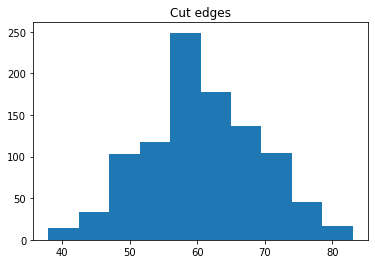

In [ ]:
plt.hist(cutedges)
plt.title("Cut edges")

## 4. Running a ReCom chain

Let's make an initial plan again.

In [ ]:
total_population = sum([graph.nodes[n][pop_col] for n in graph.nodes])
assignment = recursive_tree_part(
    graph,
    range(4), #district names, in this case {0,1,2,3}
    total_population/4, #ideal population for a district
    pop_col,
    0.05 #maximum allowed population deviation, 5% for now
)
#make a GerryChain Partition object
initial_partition = Partition(graph, assignment, myupdaters)

Running a ReCom chain is a simple matter of changing the proposal function, and adjusting the constraints.

In [ ]:
#no need for contiguity since that is forced by the proposal
myconstraints = [
    constraints.within_percent_of_ideal_population(initial_partition, 0.05)
]
#little python trick to fix some parameters in the proposal function
myproposal = partial(
    recom,
    pop_col=pop_col,
    pop_target=total_population/4,
    epsilon=0.05, #population tolerance
    node_repeats=2 #parameter for spanning tree method, set to 2 is fine
)
chain = MarkovChain(
    proposal=myproposal,
    constraints=myconstraints,
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000 #just a few steps to start with
)

We'll store the chain's data in the same way.

In [ ]:
recomcutedges = []
votesharelists = {e: [] for e in election_names}
for i, step in enumerate(chain):
  print(step.flips)
  print(i, end=" ")
  gdf['recomstep{}'.format(i)] = [step.assignment[n] for n in graph.nodes] #store plan
  recomcutedges.append(len(step['cut_edges']))
  for e in election_names:
    votesharelists[e].append(sorted(step[e].percents("Democratic")))

None
0 {36: 2, 6: 2, 71: 2, 73: 2, 9: 2, 47: 2, 15: 2, 80: 2, 49: 2, 52: 2, 22: 2, 87: 2, 25: 2, 29: 2, 95: 2, 0: 1, 1: 1, 11: 1, 16: 1, 23: 1, 24: 1, 28: 1, 31: 1, 33: 1, 34: 1, 35: 1, 37: 1, 40: 1, 45: 1, 51: 1, 54: 1, 63: 1, 76: 1, 83: 1, 85: 1, 86: 1, 92: 1, 93: 1, 94: 1, 96: 1}
1 {2: 2, 6: 2, 9: 2, 12: 2, 13: 2, 14: 2, 15: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 26: 2, 29: 2, 30: 2, 32: 2, 39: 2, 41: 2, 42: 2, 49: 2, 50: 2, 52: 2, 56: 2, 57: 2, 60: 2, 61: 2, 64: 2, 69: 2, 72: 2, 80: 2, 84: 2, 87: 2, 90: 2, 91: 2, 95: 2, 3: 0, 7: 0, 22: 0, 25: 0, 36: 0, 43: 0, 44: 0, 46: 0, 47: 0, 48: 0, 55: 0, 58: 0, 65: 0, 66: 0, 67: 0, 68: 0, 70: 0, 71: 0, 73: 0, 77: 0, 79: 0, 97: 0}
2 {0: 1, 1: 1, 11: 1, 76: 1, 16: 1, 83: 1, 85: 1, 86: 1, 23: 1, 24: 1, 28: 1, 29: 1, 92: 1, 93: 1, 94: 1, 96: 1, 33: 1, 31: 1, 34: 1, 35: 1, 37: 1, 45: 1, 51: 1, 54: 1, 63: 1, 2: 2, 6: 2, 9: 2, 12: 2, 13: 2, 14: 2, 15: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 26: 2, 30: 2, 32: 2, 39: 2, 40: 2, 41: 2, 42: 2, 49: 2, 50: 2,

KeyboardInterrupt: ignored

Just for fun, let's plot the tenth step in the chain again. How does it compare to the seed? **Go ahead and look at other plans too. See how they change from one step to the next.**

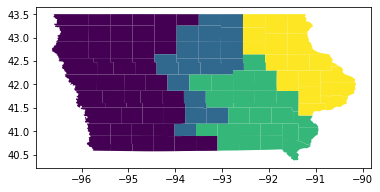

In [ ]:
initial_partition.plot(gdf)

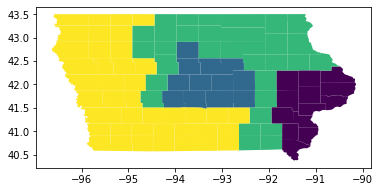

In [ ]:
gdf.plot(column="recomstep{}".format(100))

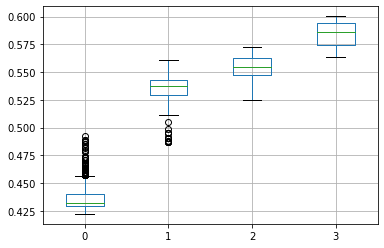

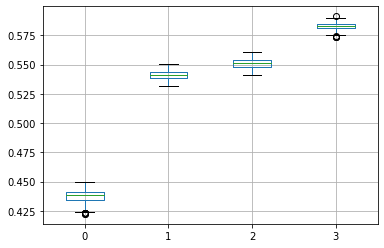

In [ ]:
recomvoteshares = pd.DataFrame(votesharelists['PRES12'])
recomvoteshares.boxplot()
plt.show()
flipvoteshares.boxplot()
plt.show()

We can easily store our vote share data for later as a csv.

In [ ]:
recomvoteshares.to_csv(
    'PRES12_D_ReCom_shares.csv',
    index_label='step'
)

Let's look at the cut edges scores along side the Recom cut edges from earlier.

Text(0.5, 1.0, 'Flip cut edges')

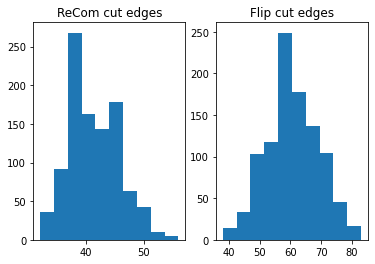

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].hist(recomcutedges)
ax[0].set_title("ReCom cut edges")
ax[1].hist(cutedges)
ax[1].set_title("Flip cut edges")

And that's it! Feel free to go ahead and play with the parameters above, store different kinds of data for the runs, or even try a whole new state from mggg-states.

## Some bonus challenges

### In QGIS
You can store a special plan to look at later in QGIS. For example, here we will store the plan which has the most Democratic district in the ensemble. We'll add it as a column called "myplan" and save it to a shapefile.

In [ ]:
plan_with_highest_D = recomvoteshares[3].argmax()
fresh_gdf = gpd.read_file("IA_counties.shp")
fresh_gdf['myplan'] = gdf["recomstep{}".format(plan_with_highest_D)]
fresh_gdf.to_file("IA_highest_D.shp")

We can now download our file and open it up QGIS for further analysis and visualization. For example, we can plot the boundaries of myplan over the election data from PRES12.

### In GerryChain

We can replace always_accept with an acceptance function that preferentially accepts compact plans. E.g.:

In [ ]:
def myaccept(step):
  beta = 1
  proposedce = len(step['cut_edges'])
  parentce = len(step.parent['cut_edges'])
  probability_of_accept = np.exp(beta*(parentce-proposedce))
  return random.random() < probability_of_accept

Try running the chain with the myaccept function instead of always_accept. Check the histogram to make sure it's working. Play with different values of beta.

### In scipy

_Auto correlation_ refers to the amount of dependence between each step and the next in a chain. Or possibly between each step and the step some time later. It is a measure of how well your chain is exploring the space.

We can use scipy.stats.pearsonr to calculate the autocorrelation in the highest Democratic district vote share in a chain. Here it is for recom (it's the first number, the second number is a p-value, which we can ignore for now).

In [ ]:
import scipy.stats

In [ ]:
#the correlation between recomvoteshares[3] and recomvoteshares[3] shifted by one.
lag = 1
scipy.stats.pearsonr(recomvoteshares[3][:-lag], recomvoteshares[3][lag:])

Try different values instead of 1. Does the autocorrelation increase or decrease? Try it for the flip chain. Do you notice any differences between the chains?